In [4]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../src/modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import compose, pipeline, preprocessing, model_selection, neural_network, feature_selection
import seaborn as sns
from tqdm import tqdm


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

### Load all data

In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [5]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

cv_default = model_selection.KFold(n_splits=8, shuffle=False)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

lags_default = [1, 2, 3, 4, 5, 6]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6],
    "gdp": [2, 3, 4, 5, 6],
    "unempl": [2, 3, 4, 5, 6],
}



### Hypertuning

In [240]:
params = {
    "mlpregressor__hidden_layer_sizes": [
        (600, 2000),
        # (350, 450, 600),
    ],
    "mlpregressor__learning_rate": ["adaptive"],
    "mlpregressor__early_stopping": [True, False],
    # "mlpregressor__alpha": [0.1, 0.2],
    # "mlpregressor__learning_rate_init": [0.001,],
    "mlpregressor__solver": ["adam"],
}


labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["19", "gdp", "unempl"],
    lags=lags_default,
    alternate_lags=alternate_lags_default,
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=neural_network.MLPRegressor(random_state=42, tol=1e-5, validation_fraction=0.2),
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    params=params,
    scoring=eumf_eval.scorer_mae,
    cv=cv_default
    # dummy_encoder="drop",
)
estimator = tuner.best_estimator_

cv_score = eumf_eval.score_cv(estimator, train_stacked, cv=cv_default,)

test_score = eumf_eval.score_test(estimator, test_stacked,)


In [241]:
pd.DataFrame(tuner.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_mlpregressor__early_stopping param_mlpregressor__hidden_layer_sizes param_mlpregressor__learning_rate param_mlpregressor__solver                       params                        split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  split5_test_score  split6_test_score  split7_test_score  mean_test_score  std_test_score  rank_test_score
0       1.682         0.582          0.025            0.007                     True                                     600                           adaptive                        adam             {'mlpregressor__early_stopping': True, 'mlpreg...       -0.155             -0.172             -0.146             -0.079             -0.103             -0.092             -0.146             -0.099            -0.124            0.032            10       
1      22.636         4.987          0.043            0.009                     True                             (600, 1000)                           adaptive                        adam             {'mlpregressor__early_stopping': True, 'mlpreg...       -0.159             -0.128             -0.137             -0.078             -0.127             -0.064             -0.069             -0.090            -0.106            0.033             9       
2      40.217         5.181          0.052            0.016                     True                             (600, 1500)                           adaptive                        adam             {'mlpregressor__early_stopping': True, 'mlpreg...       -0.141             -0.118             -0.108             -0.071             -0.086             -0.060             -0.075             -0.079            -0.092            0.025             5       
3      63.775        20.614          0.058            0.012                     True                             (600, 2000)                           adaptive                        adam             {'mlpregressor__early_stopping': True, 'mlpreg...       -0.139             -0.116             -0.108             -0.063             -0.078             -0.059             -0.064             -0.073            -0.087            0.028             1       
4      82.591        10.112          0.057            0.007                     True                             (600, 2500)                           adaptive                        adam             {'mlpregressor__early_stopping': True, 'mlpreg...       -0.139             -0.107             -0.122             -0.066             -0.083             -0.073             -0.077             -0.076            -0.093            0.025             6       
5       4.908         0.398          0.025            0.004                    False                                     600                           adaptive                        adam             {'mlpregressor__early_stopping': False, 'mlpre...       -0.165             -0.137             -0.134             -0.076             -0.078             -0.067             -0.068             -0.089            -0.102            0.035             8       
6      52.027         6.236          0.062            0.028                    False                             (600, 1000)                           adaptive                        adam             {'mlpregressor__early_stopping': False, 'mlpre...       -0.142             -0.115             -0.119             -0.072             -0.070             -0.063             -0.084             -0.087            -0.094            0.026             7       
7      88.760        14.670          0.052            0.016                    False                             (600, 1500)                           adaptive                        adam             {'mlpregressor__early_stopping': False, 'mlpre...       -0.139             -0.122             -0.111             -0.064             -0.072             -0.060             -0.075           

In [224]:
eumf_eval.agg_cv_scores(cv_score)

mean    std      sem   
fit_time                 2.439  1.135  4.013e-01
score_time               0.011  0.001  3.936e-04
test_mae                -0.084  0.027  9.620e-03
test_rmse               -0.125  0.050  1.767e-02
test_explained_variance  0.116  0.142  5.035e-02
test_r2_mod              0.254  0.283  1.001e-01
test_delta_mae           0.033  0.049  1.734e-02

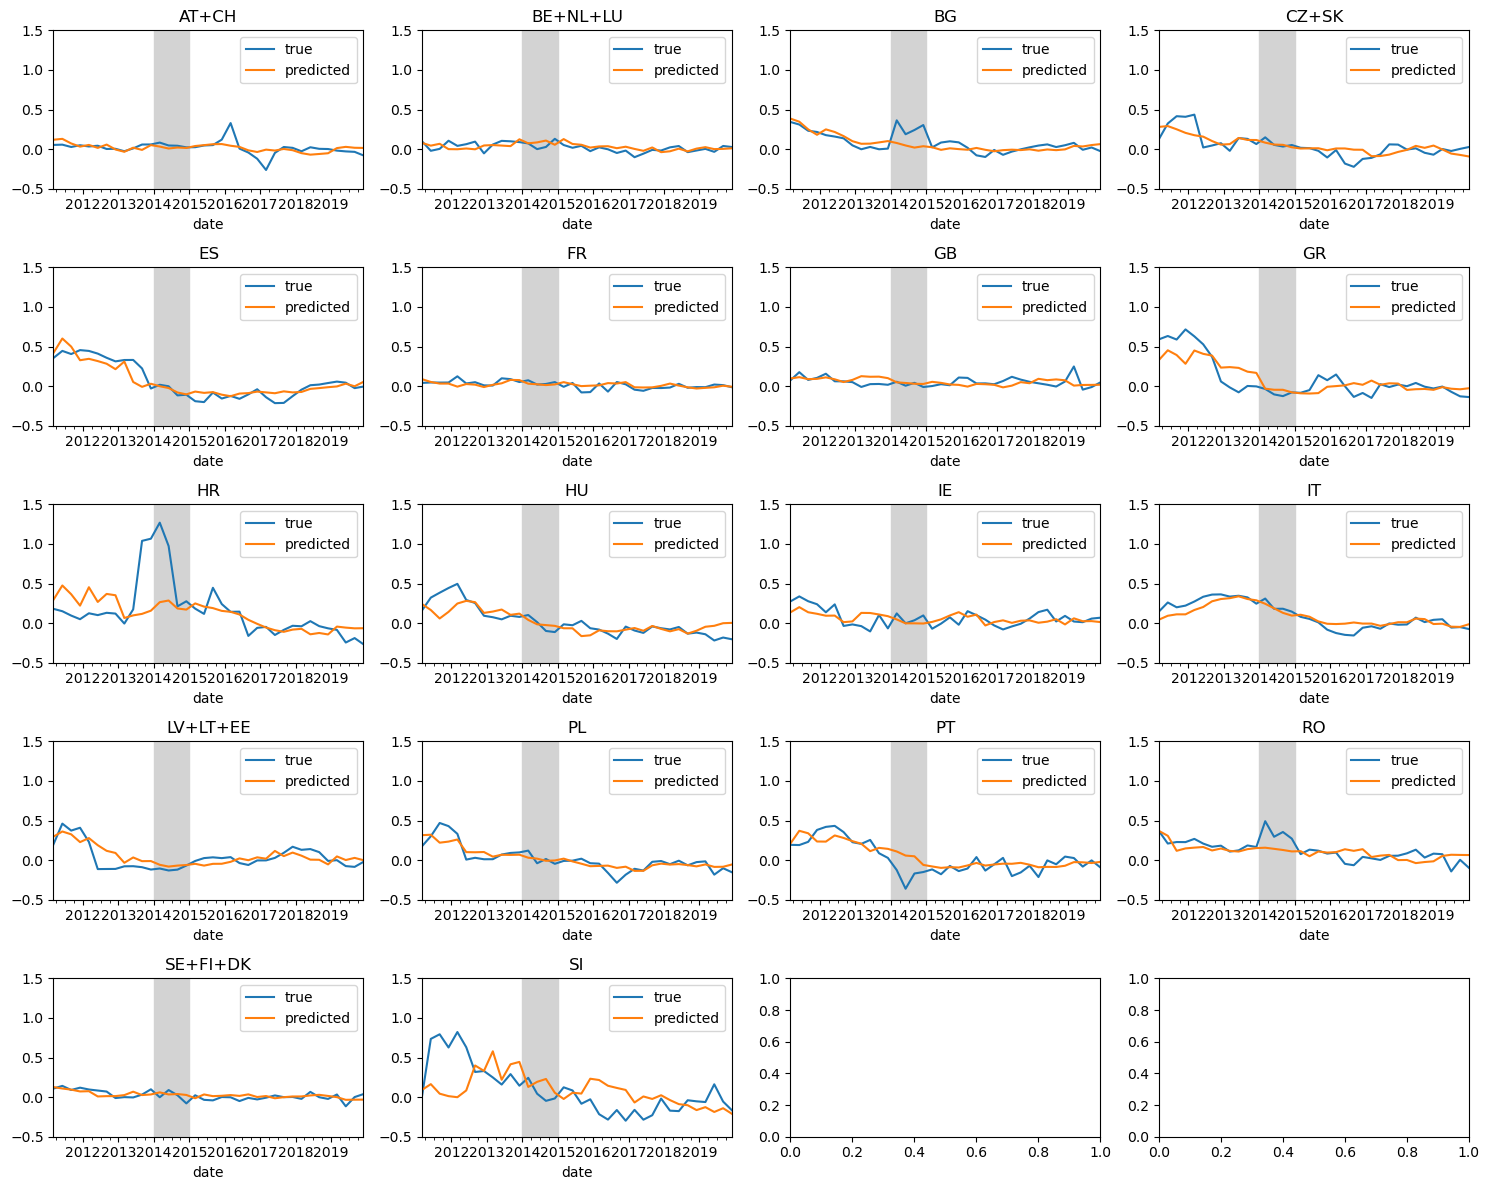

In [226]:
y_pred_all = eumf_eval.predict_all(estimator, train_stacked, test_stacked, cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()


### Random Forest - possible feature combinations

In [4]:
### TRAINING
lags_default = [1, 2, 3, 4, 5, 6]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6],
    "gdp": [2, 3, 4, 5, 6],
    "unempl": [2, 3, 4, 5, 6],
}


model_names = [
    "bench-rw",
    "bench-rw-realistic",
    "19",
    "gdp+unempl",
    "19+gdp+unempl",
    "ar",
    "ar+19",
    "ar+gdp+unempl",
    "ar+19+gdp+unempl",
]

feature_combinations = [
    ["value"],
    ["value"],
    ["19"],
    ["gdp", "unempl"],
    ["19", "gdp", "unempl"],
    ["value"],
    ["value", "19"],
    ["value", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
    ["value", "19", "24", "gdp", "unempl"],
]

lags = [
    [1],
    [2],
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
]

alternate_lags = [
    {},
    {},
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
]

use_linear_dummy = [True, True, False, False, False, False, False, False, False]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16, 32],
}

for i, name in enumerate(tqdm(model_names)):

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=feature_combinations[i],
        lags=lags[i],
        alternate_lags=alternate_lags[i],        
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    if use_linear_dummy[i]:
        tuner = None
        estimator = eumf_custom_models.make_linear_dummy_model(
            train_stacked, features=[feature_combinations[i][0] + "_" + str(lags[i][0])]
        )
    else:
        tuner = eumf_pipeline.train_reg_model(
            train_stacked,
            reg=ensemble.RandomForestRegressor(random_state=42),
            extra_pipeline_steps=[preprocessing.StandardScaler()],
            params=params,
            scoring=eumf_eval.scorer_rmse,
            # dummy_encoder="drop",
        )
        estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(estimator, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(estimator, test_stacked,)
    test_scores.append(test_score)


100%|██████████| 9/9 [02:53<00:00, 19.26s/it]


In [5]:
pd.DataFrame(
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }
).transpose()



randomforestregressor__max_features randomforestregressor__min_samples_leaf randomforestregressor__min_samples_split
19                               sqrt                                    1                                       4                   
gdp+unempl                       sqrt                                    1                                       4                   
19+gdp+unempl                    sqrt                                    1                                       8                   
ar                               auto                                    8                                       2                   
ar+19                            auto                                    8                                      32                   
ar+gdp+unempl                    sqrt                                    4                                       2                   
ar+19+gdp+unempl                 auto                                    2                                      16

In [6]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                   score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                     mean    std      sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
bench-rw             0.004   0.002  5.592e-04    0.007    1.104e-03  3.904e-04  -0.066   0.011  0.004   -0.098   0.023  0.008           0.349          0.229  0.081     0.449    0.282  0.100      0.051      0.067  0.024
bench-rw-realistic   0.004   0.001  4.149e-04    0.007    1.412e-03  4.991e-04  -0.087   0.021  0.007   -0.127   0.044  0.016           0.059          0.179  0.063     0.193    0.304  0.107      0.030      0.057  0.020
19                   0.143   0.013  4.754e-03    0.014    1.151e-03  4.069e-04  -0.084   0.029  0.010   -0.125   0.048  0.017           0.128          0.267  0.094     0.227    0.363  0.128      0.033      0.046  0.016
gdp+unempl           0.169   0.021  7.403e-03    0.015    2.890e-03  1.022e-03  -0.094   0.035  0.012   -0.126   0.049  0.017           0.128          0.163  0.057     0.246    0.258  0.091      0.023      0.043  0.015
19+gdp+unempl        0.252   0.060  2.132e-02    0.025    9.708e-03  3.432e-03  -0.083   0.026  0.009   -0.117   0.043  0.015           0.208          0.168  0.060     0.321    0.271  0.096      0.035      0.049  0.017
ar                   0.157   0.016  5.565e-03    0.012    7.566e-04  2.675e-04  -0.086   0.028  0.010   -0.122   0.048  0.017           0.199          0.134  0.047     0.300    0.264  0.093      0.032      0.049  0.017
ar+19                0.227   0.020  6.962e-03    0.012    9.933e-04  3.512e-04  -0.079   0.023  0.008   -0.113   0.043  0.015           0.265          0.168  0.059     0.370    0.259  0.091      0.038      0.053  0.019
ar+gdp+unempl        0.140   0.020  7.033e-03    0.013    2.426e-03  8.578e-04  -0.085   0.031  0.011   -0.119   0.051  0.018           0.242          0.133  0.047     0.349    0.205  0.072      0.032      0.047  0.017
ar+19+gdp+unempl     0.407   0.033  1.171e-02    0.012    1.038e-03  3.668e-04  -0.080   0.024  0.008   -0.112   0.042  0.015           0.252          0.172  0.061     0.378    0.247  0.087      0.038      0.052  0.018

In [7]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names).sort_values("rmse", ascending=False)

mae   rmse   explained_variance  r2_mod  delta_mae
bench-rw           -0.090 -0.142         0.624         0.658    0.052  
ar                 -0.087 -0.149         0.582         0.623    0.055  
ar+19              -0.099 -0.165         0.485         0.538    0.043  
ar+19+gdp+unempl   -0.111 -0.180         0.384         0.449    0.031  
19                 -0.109 -0.191         0.351         0.382    0.033  
bench-rw-realistic -0.109 -0.192         0.348         0.376    0.033  
ar+gdp+unempl      -0.127 -0.197         0.275         0.342    0.015  
19+gdp+unempl      -0.127 -0.201         0.235         0.316    0.015  
gdp+unempl         -0.155 -0.229         0.029         0.107   -0.013

#### Performance by year (CV+test)

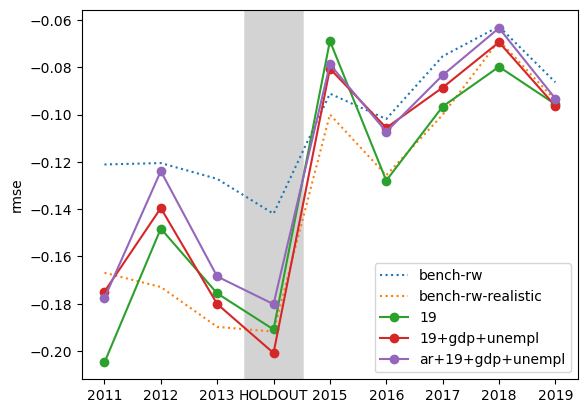

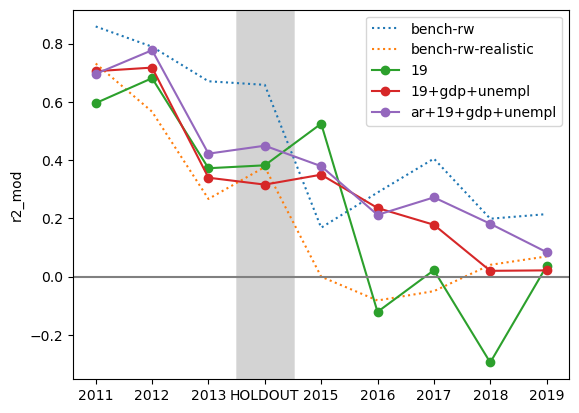

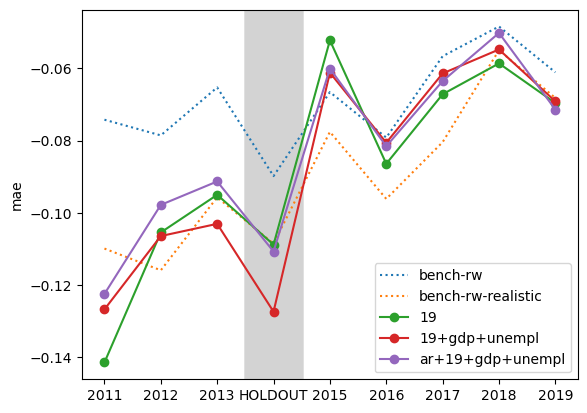

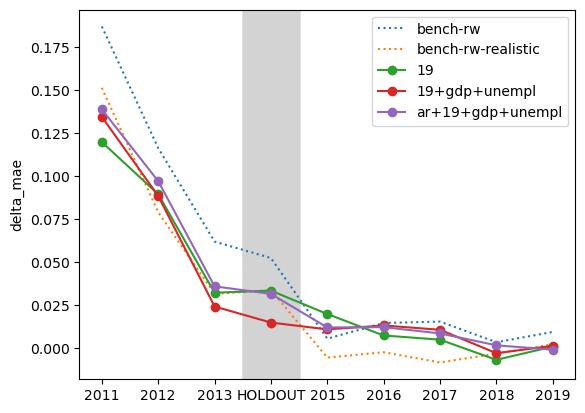

In [8]:
comp_models = ["bench-rw", "bench-rw-realistic", "19", "19+gdp+unempl", "ar+19+gdp+unempl"]

indices = [model_names.index(name) for name in comp_models]
benchmark_indices = [0, 1]
metrics = ["rmse", "r2_mod", "mae", "delta_mae"]

fold_labels = [2011, 2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

for m in metrics:
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=model_names,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=fold_labels.index("HOLDOUT"),
        benchmark_indices=benchmark_indices,
    )
    if m=="r2_mod":
        plt.axhline(0.0, c="grey")
    plt.show()

#### Performance by country

##### prepare dummy scores (realistic)

In [9]:
test_scores_c_dummy = eumf_eval.score_test_countries(estimators[1], test_stackeds[1])
cv_scores_c_dummy = eumf_eval.score_cv_countries(estimators[1], train_unstackeds[1], cv_default)

##### best model without AR lags: KW19 + econ

test scores

In [10]:
i = model_names.index("19+gdp+unempl")


In [11]:
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse"] = -test_scores_c["rmse"]
test_scores_c["mae"] = -test_scores_c["mae"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


mae   rmse   explained_variance  r2_mod  delta_mae
IT        0.027  0.039         0.717         0.967    0.178  
CZ+SK     0.038  0.044         0.062         0.733    0.033  
FR        0.023  0.029        -0.306         0.621    0.020  
LV+LT+EE  0.067  0.069         0.389         0.595    0.039  
HU        0.060  0.065         0.469         0.490    0.021  
HR        0.437  0.588         0.025         0.484    0.246  
BG        0.213  0.222         0.042         0.378    0.061  
RO        0.275  0.288         0.004         0.371    0.078  
PL        0.061  0.063         0.274         0.141   -0.006  
SE+FI+DK  0.046  0.059         0.083         0.070    0.002  
AT+CH     0.054  0.055         0.805        -0.089   -0.006  
GB        0.035  0.039        -1.164        -0.258   -0.007  
IE        0.093  0.105         0.009        -0.706   -0.028  
BE+NL+LU  0.092  0.105        -0.068        -0.929   -0.035  
PT        0.294  0.324        -1.129        -1.132   -0.093  
SI        0.158  0.194        -0.017        -1.362   -0.070  
ES        0.118  0.124         0.611        -1.372   -0.057  
GR        0.200  0.206        -1.259        -3.947   -0.113

CV scores

In [33]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("mae", "mean"), ascending=False))


CV scores per country:


mae                  rmse                explained_variance                  r2_mod                 delta_mae              
          mean   std    sem    mean   std    sem          mean          std     sem     mean    std     sem      mean    std    sem  
SI        0.164  0.113  0.040  0.187  0.124  0.044       -0.039         0.178   0.063   0.383   0.393   0.139    0.084   0.102  0.036
HR        0.156  0.140  0.050  0.188  0.182  0.064       -0.005         0.425   0.150  -0.004   0.585   0.207    0.031   0.054  0.019
GR        0.153  0.119  0.042  0.163  0.118  0.042       -0.492         1.324   0.468  -9.015  25.791   9.118    0.021   0.183  0.065
ES        0.108  0.046  0.016  0.124  0.054  0.019       -0.326         0.617   0.218  -0.936   4.039   1.428    0.083   0.110  0.039
HU        0.097  0.062  0.022  0.111  0.073  0.026       -0.967         2.294   0.811   0.319   0.649   0.229    0.052   0.050  0.018
LV+LT+EE  0.088  0.058  0.021  0.100  0.065  0.023       -0.107         0.713   0.252  -1.425   4.700   1.662    0.020   0.066  0.023
PT        0.087  0.053  0.019  0.099  0.055  0.020        0.051         0.434   0.154   0.418   0.535   0.189    0.063   0.108  0.038
CZ+SK     0.083  0.061  0.022  0.103  0.075  0.027        0.118         0.309   0.109  -0.056   0.897   0.317    0.023   0.038  0.013
IT        0.082  0.060  0.021  0.090  0.059  0.021       -0.283         0.805   0.285   0.116   0.968   0.342    0.062   0.104  0.037
PL        0.077  0.061  0.022  0.089  0.068  0.024       -0.124         0.816   0.289   0.128   1.355   0.479    0.037   0.046  0.016
IE        0.075  0.023  0.008  0.087  0.025  0.009       -0.418         0.707   0.250  -0.045   0.549   0.194    0.022   0.072  0.026
BG        0.071  0.041  0.014  0.078  0.038  0.013       -1.003         2.123   0.751 -10.630  30.233  10.689    0.010   0.096  0.034
RO        0.064  0.016  0.006  0.074  0.019  0.007       -1.047         2.201   0.778   0.321   0.589   0.208    0.058   0.078  0.028
AT+CH     0.063  0.059  0.021  0.077  0.072  0.026       -0.290         0.682   0.241  -0.372   1.307   0.462   -0.009   0.032  0.011
BE+NL+LU  0.049  0.019  0.007  0.056  0.019  0.007       -0.571         1.172   0.414  -1.001   2.135   0.755   -0.003   0.030  0.011
GB        0.049  0.029  0.010  0.061  0.034  0.012       -0.955         1.853   0.655  -0.847   3.585   1.267    0.013   0.035  0.012
SE+FI+DK  0.036  0.016  0.006  0.043  0.017  0.006       -0.150         0.493   0.174  -0.114   0.683   0.241    0.007   0.030  0.011
FR        0.033  0.014  0.005  0.040  0.017  0.006      -19.575        54.244  19.178   0.012   0.617   0.218    0.008   0.011  0.004

plot RMSE absolute

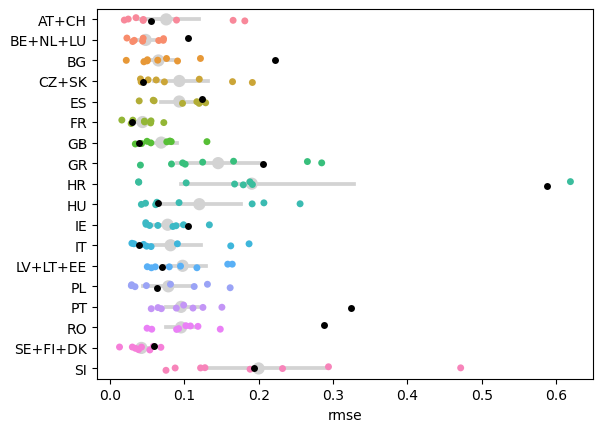

In [13]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot MAE absolute

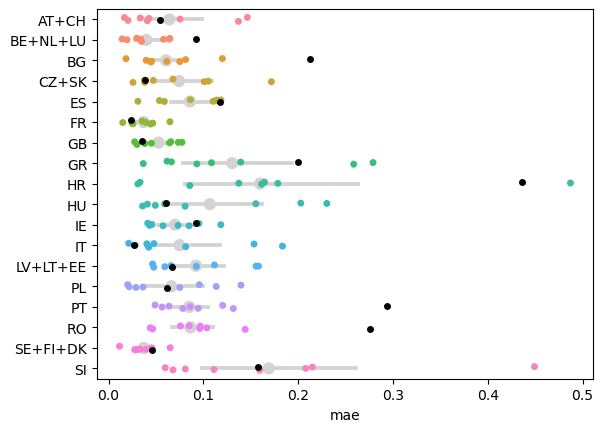

In [14]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()


plot MAE delta

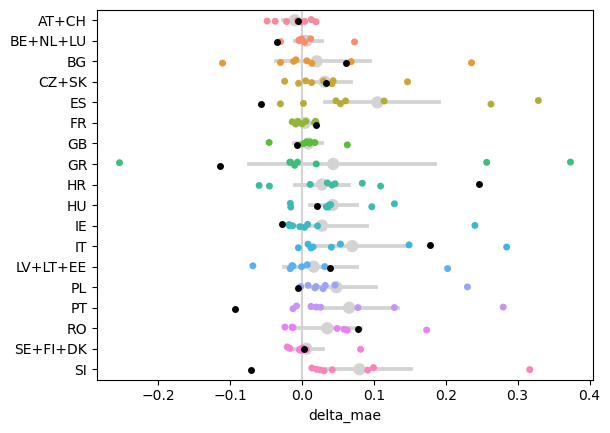

In [15]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="delta_mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="delta_mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="delta_mae", color="k")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.show()


##### best model with AR lags: value + KW19 + econ

test scores

In [34]:
i = model_names.index("ar+19+gdp+unempl")


In [35]:
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse"] = -test_scores_c["rmse"]
test_scores_c["mae"] = -test_scores_c["mae"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


mae   rmse   explained_variance  r2_mod  delta_mae
IT        0.018  0.019         0.935         0.992    0.187  
FR        0.011  0.014         0.660         0.911    0.032  
CZ+SK     0.030  0.042         0.255         0.751    0.042  
LV+LT+EE  0.053  0.056         0.428         0.736    0.053  
HR        0.417  0.512         0.078         0.609    0.265  
RO        0.229  0.245        -0.010         0.547    0.124  
BG        0.189  0.204        -0.297         0.478    0.085  
AT+CH     0.038  0.039         0.856         0.453    0.010  
BE+NL+LU  0.052  0.061         0.267         0.359    0.005  
HU        0.068  0.075         0.346         0.321    0.014  
PL        0.054  0.056         0.375         0.313    0.001  
GB        0.026  0.030        -0.218         0.292    0.003  
SE+FI+DK  0.040  0.055         0.201         0.194    0.009  
IE        0.077  0.083         0.600        -0.071   -0.013  
PT        0.237  0.272        -1.051        -0.505   -0.036  
ES        0.105  0.114        -0.445        -1.004   -0.044  
SI        0.168  0.218        -1.030        -1.994   -0.081  
GR        0.154  0.164        -1.656        -2.123   -0.068

CV scores

In [36]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("rmse", "mean"), ascending=False))


CV scores per country:


mae                  rmse                explained_variance                 r2_mod               delta_mae               
          mean   std    sem    mean   std    sem          mean          std     sem    mean   std    sem      mean     std    sem  
HR        0.165  0.134  0.047  0.198  0.178  0.063       -7.804        19.543   6.910 -0.188  0.914  0.323  2.273e-02  0.058  0.021
SI        0.176  0.127  0.045  0.195  0.136  0.048       -0.657         0.584   0.206  0.221  0.588  0.208  7.253e-02  0.114  0.040
GR        0.102  0.057  0.020  0.116  0.060  0.021       -0.740         1.961   0.693 -2.811  8.203  2.900  7.132e-02  0.198  0.070
LV+LT+EE  0.085  0.041  0.014  0.105  0.054  0.019       -1.729         2.702   0.955 -1.992  5.392  1.906  2.283e-02  0.097  0.034
PT        0.087  0.033  0.012  0.097  0.038  0.013       -0.284         0.597   0.211  0.461  0.401  0.142  6.385e-02  0.089  0.032
HU        0.082  0.050  0.018  0.095  0.058  0.021       -0.829         1.551   0.548  0.467  0.535  0.189  6.698e-02  0.067  0.024
CZ+SK     0.077  0.045  0.016  0.094  0.057  0.020        0.129         0.293   0.103 -0.347  1.729  0.611  2.856e-02  0.054  0.019
IE        0.082  0.031  0.011  0.092  0.035  0.012       -2.263         5.589   1.976 -0.089  0.729  0.258  1.619e-02  0.053  0.019
RO        0.077  0.017  0.006  0.089  0.022  0.008       -1.590         2.715   0.960  0.134  0.654  0.231  4.410e-02  0.069  0.024
ES        0.079  0.032  0.011  0.088  0.036  0.013       -0.300         1.043   0.369 -0.027  1.975  0.698  1.119e-01  0.129  0.046
PL        0.068  0.043  0.015  0.076  0.048  0.017        0.070         0.682   0.241  0.486  0.385  0.136  4.565e-02  0.091  0.032
IT        0.066  0.040  0.014  0.074  0.042  0.015       -0.450         1.162   0.411  0.436  0.506  0.179  7.813e-02  0.102  0.036
BG        0.065  0.017  0.006  0.072  0.024  0.008       -1.468         2.511   0.888 -3.372  9.612  3.399  1.653e-02  0.075  0.026
AT+CH     0.057  0.052  0.018  0.069  0.064  0.022       -0.419         1.027   0.363 -0.222  1.137  0.402 -3.366e-03  0.024  0.009
GB        0.052  0.034  0.012  0.062  0.038  0.013       -0.775         1.621   0.573 -0.479  2.440  0.863  9.737e-03  0.033  0.012
BE+NL+LU  0.045  0.014  0.005  0.052  0.014  0.005       -0.948         1.813   0.641 -0.299  0.675  0.239  3.809e-04  0.017  0.006
SE+FI+DK  0.037  0.018  0.006  0.043  0.018  0.007       -0.111         0.460   0.163  0.024  0.521  0.184  6.444e-03  0.022  0.008
FR        0.032  0.013  0.005  0.040  0.016  0.006      -12.049        31.918  11.285  0.018  0.602  0.213  8.729e-03  0.013  0.004

plot RMSE absolute

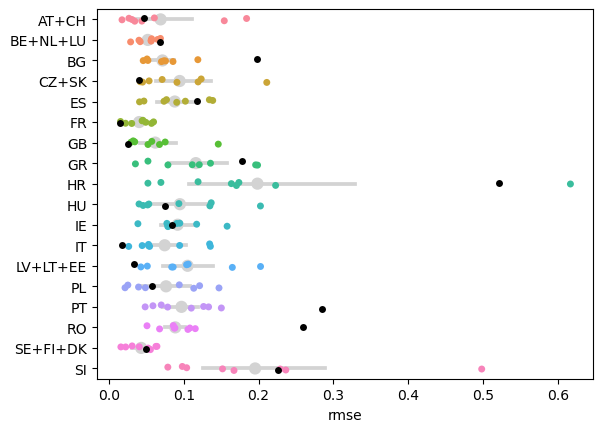

In [19]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot MAE absolute

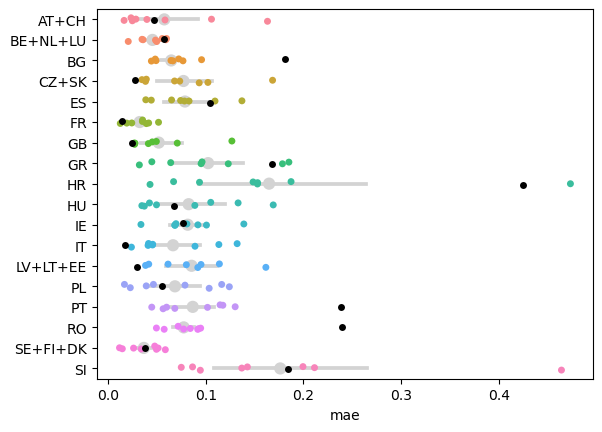

In [20]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()


plot MAE delta

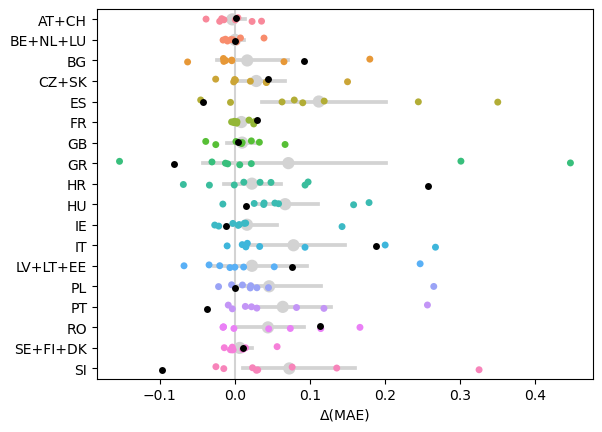

In [21]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="delta_mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="delta_mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="delta_mae", color="k")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


#### How important is Google Trends for each country? (diff KW19 vs no KW19)


##### without own lags

In [22]:
i1 = model_names.index("19+gdp+unempl")
i2 = model_names.index("gdp+unempl")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0)

cv_diff_agg["rmse"]

mean      std    sem 
AT+CH     1.734e-02  0.021  0.007
BE+NL+LU  2.964e-02  0.042  0.015
BG        2.323e-02  0.035  0.012
CZ+SK     1.821e-04  0.012  0.004
ES        6.453e-02  0.055  0.019
FR        2.661e-03  0.012  0.004
GB        1.339e-03  0.017  0.006
GR        2.133e-02  0.027  0.010
HR        2.082e-02  0.031  0.011
HU        1.020e-03  0.033  0.012
IE        5.528e-03  0.029  0.010
IT        2.118e-02  0.042  0.015
LV+LT+EE  2.483e-03  0.020  0.007
PL        9.362e-03  0.028  0.010
PT        2.836e-03  0.026  0.009
RO       -2.515e-03  0.021  0.008
SE+FI+DK  4.392e-03  0.005  0.002
SI       -2.286e-02  0.051  0.018

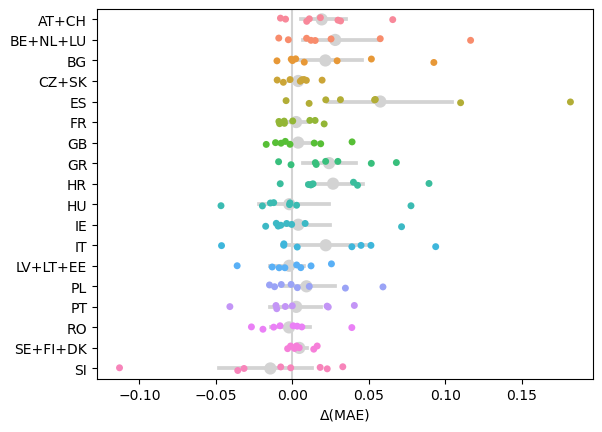

In [23]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
# sns.boxenplot(
#     data=cv_diff.reset_index(),
#     y="level_0",
#     x="mae",
#     # linestyles="",
#     # color="lightgrey",
#     # linewidth=0.0
# )
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


##### with own lags

In [24]:
i1 = model_names.index("ar+19+gdp+unempl")
i2 = model_names.index("ar+gdp+unempl")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0,)

cv_diff_agg["rmse"]

mean      std    sem 
AT+CH     7.458e-03  0.013  0.005
BE+NL+LU  3.975e-03  0.017  0.006
BG        6.035e-03  0.039  0.014
CZ+SK     8.729e-03  0.021  0.008
ES        3.599e-02  0.032  0.011
FR       -1.946e-04  0.007  0.003
GB       -5.570e-04  0.008  0.003
GR        4.700e-02  0.067  0.024
HR       -1.037e-02  0.033  0.012
HU        1.624e-02  0.027  0.010
IE       -5.194e-03  0.027  0.010
IT        1.514e-02  0.035  0.012
LV+LT+EE -5.571e-03  0.035  0.012
PL        1.246e-02  0.052  0.018
PT        1.969e-03  0.046  0.016
RO       -1.478e-02  0.010  0.004
SE+FI+DK  7.801e-05  0.012  0.004
SI       -8.131e-03  0.040  0.014

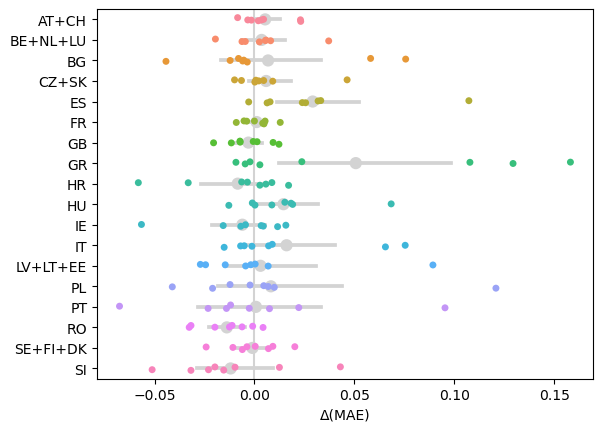

In [25]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


#### feature importance

In [26]:
i = model_names.index("19+gdp+unempl")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)

19_1                1.196e-01
unempl_6            1.004e-01
19_2                9.567e-02
unempl_5            8.908e-02
19_3                7.338e-02
unempl_4            7.315e-02
unempl_3            6.670e-02
unempl_2            6.499e-02
19_5                4.266e-02
19_4                3.986e-02
19_6                3.968e-02
gdp_2               3.565e-02
gdp_3               2.857e-02
gdp_6               2.836e-02
gdp_4               2.626e-02
gdp_5               2.307e-02
country_SI          1.067e-02
country_HR          9.968e-03
country_HU          5.197e-03
country_GR          4.920e-03
country_RO          4.843e-03
country_ES          4.796e-03
country_CZ+SK       2.042e-03
country_IE          1.642e-03
country_PL          1.288e-03
country_AT+CH       1.205e-03
country_IT          1.199e-03
country_PT          1.106e-03
country_LV+LT+EE    1.071e-03
country_BG          9.832e-04
country_GB          7.533e-04
country_BE+NL+LU    5.382e-04
country_FR          4.316e-04
country_SE

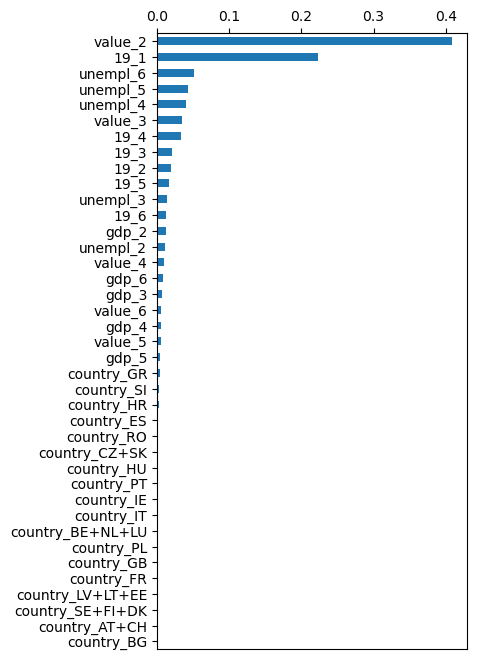

In [27]:
i = model_names.index("ar+19+gdp+unempl")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
plt.figure(figsize=(4,8))
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=True
).plot(kind="barh")
plt.gca().xaxis.tick_top()
plt.show()

#### Plot prediction

all features

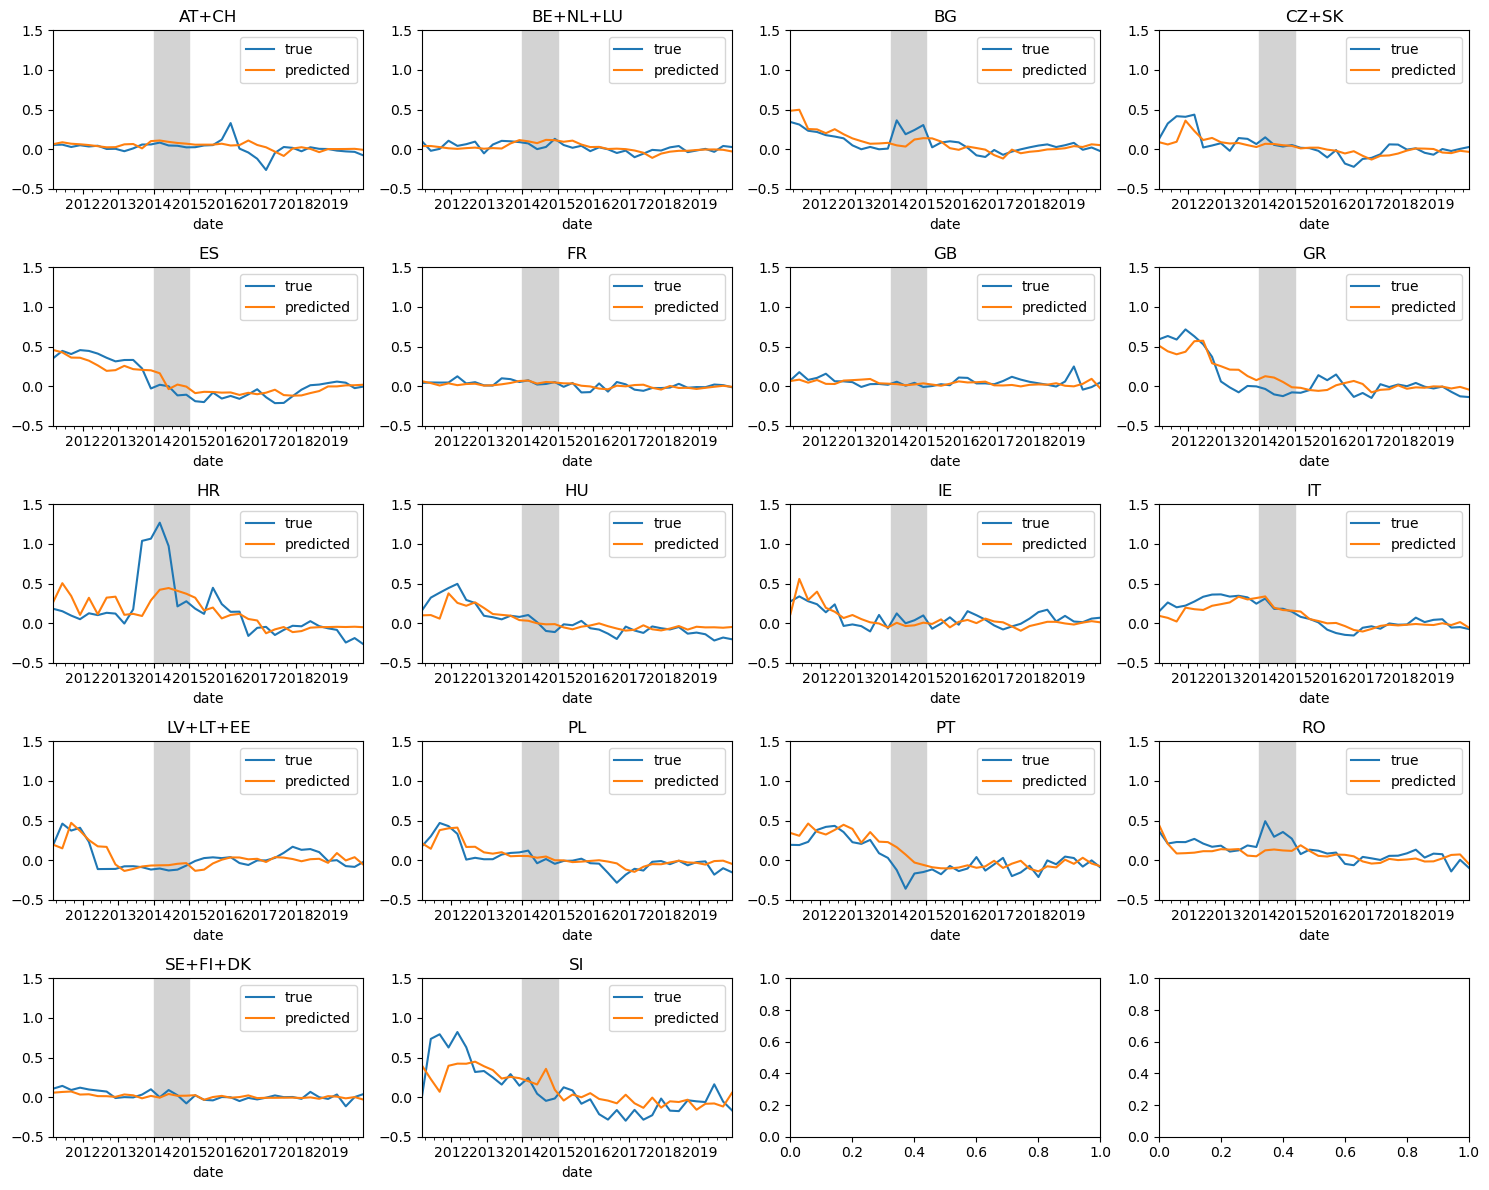

In [28]:
i = model_names.index("ar+19+gdp+unempl")
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()


Without own lags

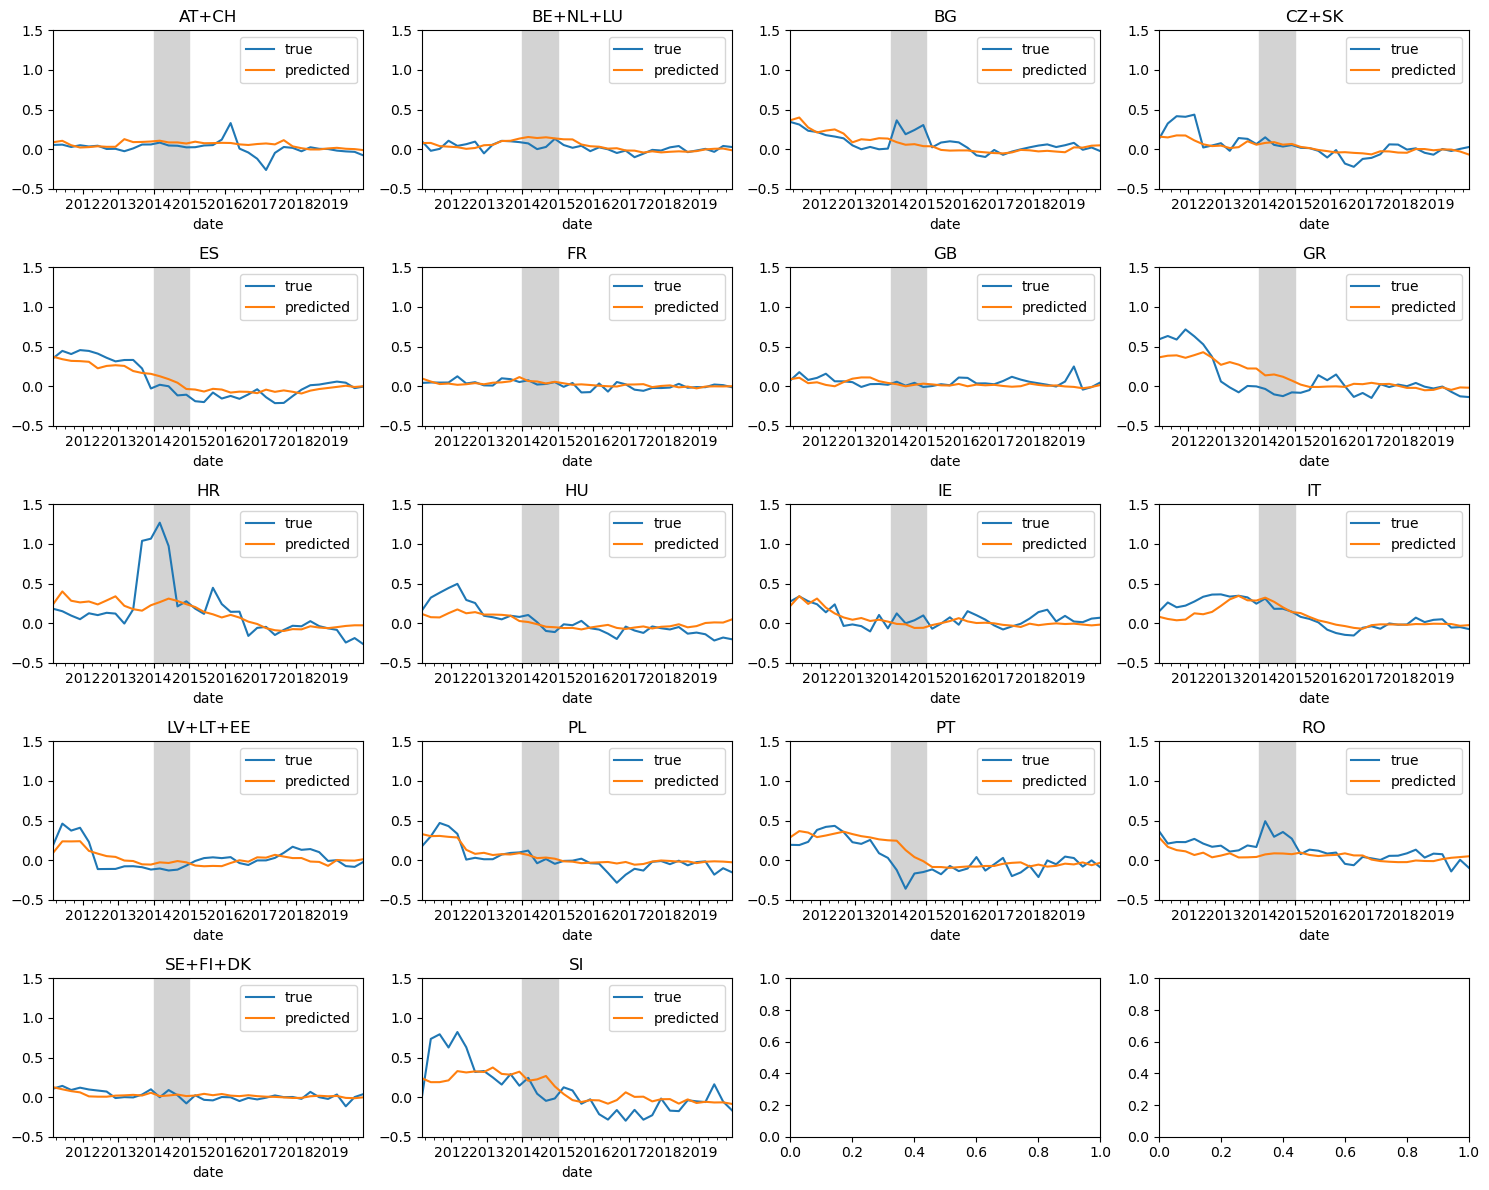

In [29]:
i = model_names.index("19+gdp+unempl")

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()

Without Google Trends

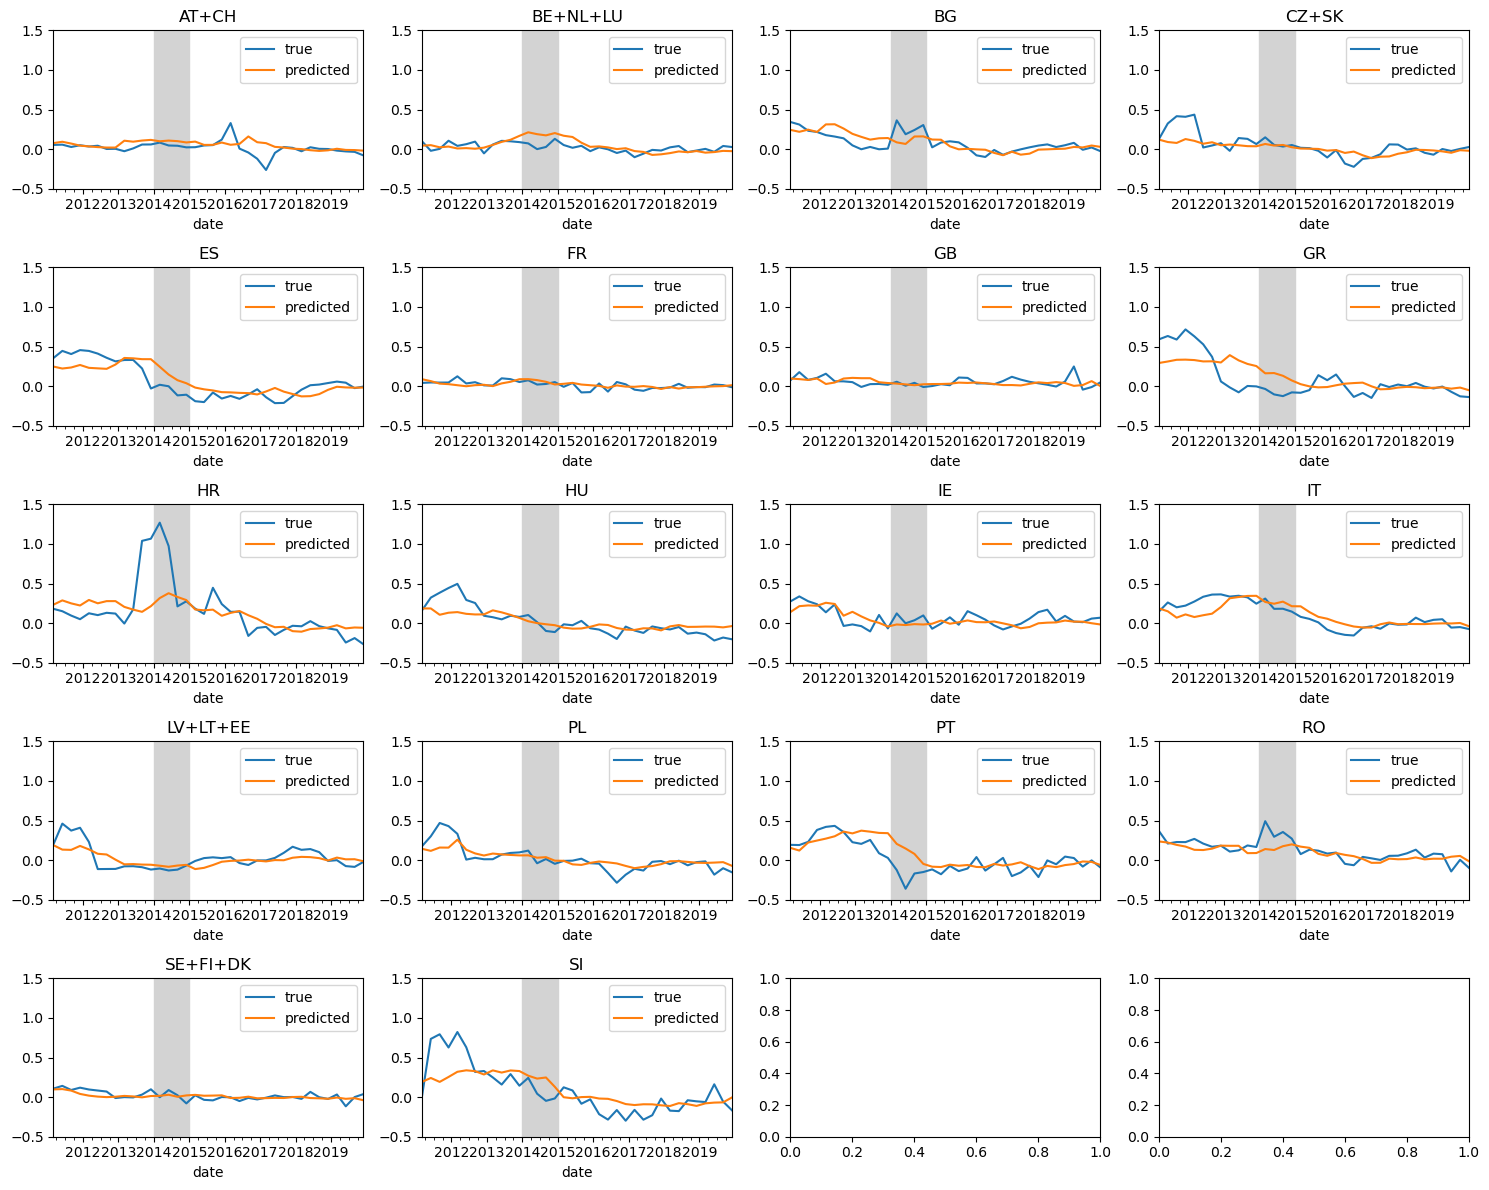

In [30]:
i = model_names.index("ar+gdp+unempl")

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()

Comparison

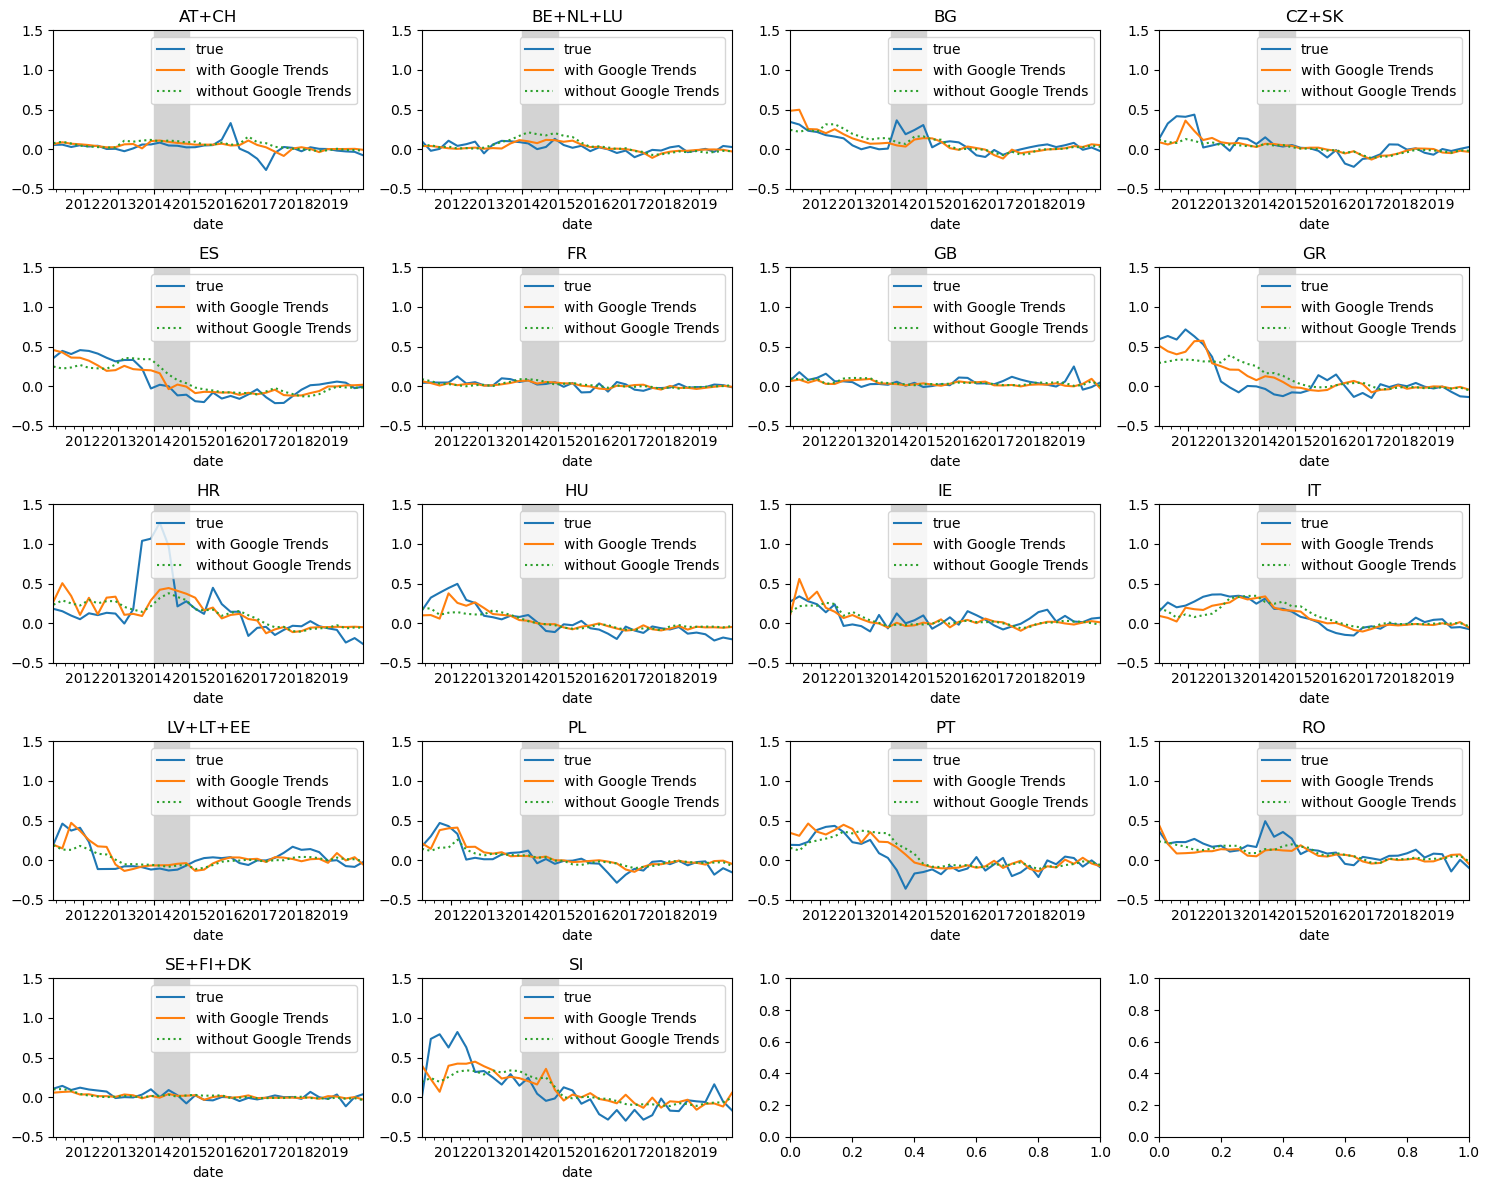

In [31]:
i1 = model_names.index("ar+19+gdp+unempl")
i2 = model_names.index("ar+gdp+unempl")

y_pred_i1 = eumf_eval.predict_all(tuners[i1].best_estimator_, train_stackeds[i1], test_stackeds[i1], cv_default)
y_pred_i2 = eumf_eval.predict_all(tuners[i2].best_estimator_, train_stackeds[i2], test_stackeds[i2], cv_default)

y_preds_all= {"with Google Trends": y_pred_i1, "without Google Trends": y_pred_i2}

fig, axs = eumf_eval.plot_predictions(
    y_preds_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
    style={"without Google Trends": ":"}
)
plt.show()